# Processing a (fake) globular cluster with the DM Science Pipelines

This notebook provides an introduction to using some of the most important pieces of the DM Science Pipelines codebase:

 - Geometry classes from `lsst.geom`, such as points and boxes.
 - Higher-level astronomical primitives from `lsst.afw`, such as the `Image`, `Exposure`, and `Psf` classes.
 - Our core algorithmic `Task` classes, including those for source detection, deblending, and measurement.
 
We'll be working with coadded images made from Subaru Hyper Suprime-Cam (HSC) data in the COSMOS field, augmented with a simulated globular cluster.  We've taken a recent LSST reprocessing of the HSC-SSP UltraDeep COSMOS field (see [this page](https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing) for information on that reprocessing, and [this page](https://hsc-release.mtk.nao.ac.jp/doc/) for the data), and added simulated stars from a scaled [SDSS catalog](http://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=photometry-of-crowded-fields-in-sdss-for-galactic-globular-and-open-clusters).  The result is a very deep image (deeper than the 10-year LSST Deep-Wide-Fast survey, though not as deep as LSST Deep Drilling fields will be) with both a large number of galaxies and region full of stars.  As we'll see, that'll present a challenge for the vanilla DM pipelines (at least today), and hence a good excuse to do some custom processing.

## Imports and Custom Installs

We'll start by with some standard imports of both LSST and third-party packages.

Most of these are already installed automatically (assuming you're using an "LSST" Jupyter Kernel, not a vanilla Python one - and you should be).  But the `tqdm` package, a nice collection of progress bar widgets for both notebooks and the command-line, is not.  That means we can use it to show how to install custom PyPI packages in the notebook environment.  Open a new Terminal tab (either via the Launcher tab, if you have one, or by the "+" button in the upper left), and type:

    pip install tqdm --user

You may need to then restart the kernel in this notebook afterwards (circle-with-arrow button, at the top of this tab).  If you can execute the next cell, it's properly installed

In [1]:
import numpy as np
from tqdm import tqdm_notebook
from lsst.daf.persistence import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT

## Reading Data

We'll be retreiving data using the `Butler` tool, which manages where various datasets are stored on the filesystem (and can in principle manage datasets that aren't even stored as files, though all of these are).

We start by creating a `Butler` instance, pointing it at a *Data Repository* (which here is just a root directory).  If you're interesting in looked at the original HSC data without the simulated cluster, change the path below to just `/datasets/hsc/cosmos`.

In [2]:
butler = Butler("/datasets/hsc/with-globular")

Datasets managed by a butler are identified by a dictionary *Data ID* (specifying things like the visit number or sky patch) and a string *DatasetType* (such as a particular image or catalog).  Different DatasetTypes have different keys, while different instances of the same Dataset Type have different values.  All of the datasets we use in this tutorial will correspond to the same patch of sky, so they'll have at least the keys in the dictionary in the next cell (they will also have `filter`, but with different values):

In [3]:
dataId = {"tract": 9813, "patch": "4,4"}

We can now use those to load a set of *griz* coadds, which we'll put directly in a dictionary.  The result of each `Butler.get` call is in this case an `lsst.afw.image.Exposure` object, an image that actually contains three "planes" (the main image, a bit mask, and a variance image) as well as many other objects that describe the image, such as its PSF and WCS.  Note that we (confusingly) use `Exposures` to hold coadd images as well as true single-exposure images.

The DatasetType here is `deepCoadd_calexp` (a coadd on which we've already done some additional processing, such as subtracting the background and setting some mask values), and the extra `filter` argument gets appended to the Data ID.

In [4]:
coadds = {b: butler.get("deepCoadd_calexp", dataId, filter="HSC-{}".format(b.upper())) for b in "griz"}

## Making and displaying color composite images

We'll start by just looking at the images, as 3-color composites.  We'll use astropy to build those as a nice way to demonstrate how to get NumPy arrays from the `Exposure` objects in the `coadds` dict.  (LSST also has code to make 3-color composites using the same algorithm, and in fact the Astropy implementation is based on ours, but now that it's in Astropy we'll probably retire ours.)

We'll just use matplotlib to display the images themselves.  We'll use Firefly for other image display tasks later, but while Firefly itself supports color-composites, it doesn't yet use our preferred composition algorithm and we haven't quite finished connecting that functionality to the Python client we'll demonstrate here.

In [5]:
from astropy.visualization import make_lupton_rgb
from matplotlib import pyplot
%matplotlib inline

We'll use the following function a few times to display color images.  It's worth reading through the implementation carefully to see what's going on.

In [6]:
def showRGB(exps, bgr="gri"):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    exps : `dict`
        Dictionary of `lsst.afw.image.Exposure` objects, keyed by filter name.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel.
    """
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=exps[bgr[2]].image.array,  # numpy array for the r channel
                          image_g=exps[bgr[1]].image.array,  # numpy array for the g channel
                          image_b=exps[bgr[0]].image.array,  # numpy array for the b channel
                          stretch=1, Q=10)  # parameters used to stretch and scale the pixel values
    pyplot.figure(figsize=(20, 15))
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = exps[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    pyplot.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))

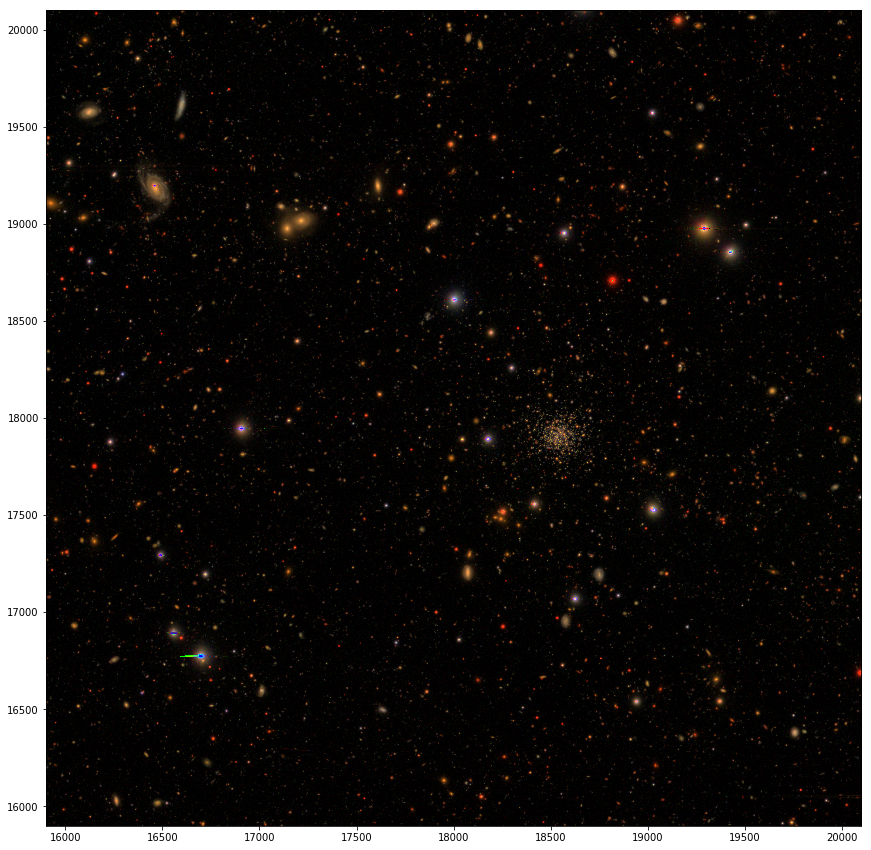

In [7]:
showRGB(coadds, bgr="gri")

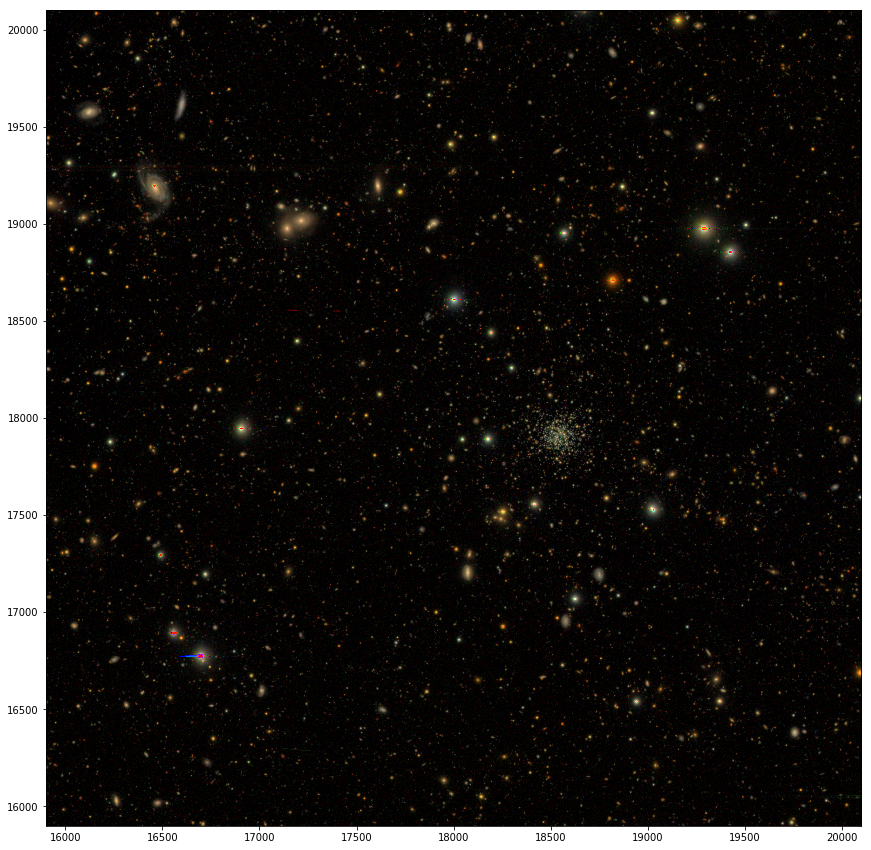

In [8]:
showRGB(coadds, bgr="riz")

Those images are a full "patch", which is our usual unit of processing for coadds - it's about the same size as a single LSST sensor (exactly the same in pixels, smaller in terms of area because these use HSC's smaller pixel scale).  That's a bit unweildy (just because waiting for processing to happen isn't fun in a tutorial setting), so we'll reload our dict with sub-images centered on the cluster.  Note that we can load the sub-images directly with the `butler`, by appending `_sub` to the DatasetType and passing a `bbox` argument.

In [9]:
coadds = {b: butler.get("deepCoadd_calexp_sub", dataId, filter="HSC-{}".format(b.upper()),
                        bbox=Box2I(minimum=Point2I(18325, 17725), dimensions=Extent2I(400, 350)))
          for b in "griz"}

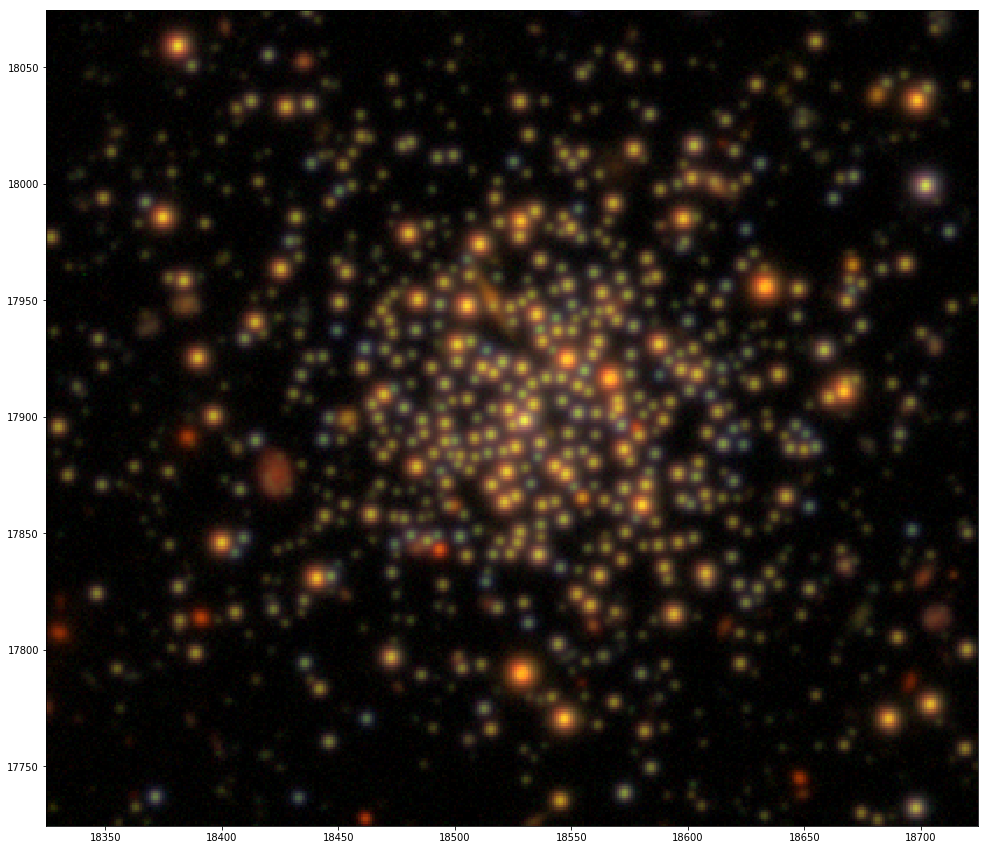

In [10]:
showRGB(coadds, "gri")

## Basic Processing

Now we'll try the regular LSST processing tasks, with a simpler configuration than we usually use to process coadds, just to avoid being distracted by complexity.  This includes

 - Detection (`SourceDetectionTask`): given an `Exposure`, find above-threshold regions and peaks within them (`Footprints`), and create a *parent* source for each `Footprint`.
 - Deblending (`SourceDeblendTask`): given an `Exposure` and a catalog of parent sources, create a *child* source for each peak in every `Footprint` that contains more than one peak.  Each child source is given a `HeavyFootprint`, which contains both the pixel region that source covers and the fractional pixel values associated with that source.
 - Measurment (`SingleFrameMeasurementTask`): given an `Exposure` and a catalog of sources, run a set of "measurement plugins" on each source, using deblended pixel values if it is a child.

We'll start by importing these, along with the `SourceCatalog` class we'll use to hold the outputs.

In [12]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

We'll now construct all of these `Tasks` before actually running any of them.  That's because `SourceDeblendTask` and `SingleFrameMeasurementTask` are constructed with a `Schema` object that records what fields they'll produce, and they modify that schema when they're constructed by adding columns to it.  When we run the tasks later, they'll need to be given a catalog that includes all of those columns, but we can't add columns to a catalog that already exists.

To recap, the sequence looks like this:

 1. Make a (mostly) empty schema.
 2. Construct all of the `Task`s (in the order you plan to run them), which adds columns to the schema.
 3. Make a `SourceCatalog` object from the *complete* schema.
 4. Pass the same `SourceCatalog` object to each `Task` when you run it.

In [13]:
schema = SourceCatalog.Table.makeMinimalSchema()

detectionTask = SourceDetectionTask(schema=schema)

deblendTask = SourceDeblendTask(schema=schema)

# We'll customize the configuration of measurement to just run a few plugins.
# The default list of plugins is much longer (and hence slower).
measureConfig = SingleFrameMeasurementTask.ConfigClass()
measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux"]
# "Slots" are aliases that provide easy access to certain plugins.
# Because we're not running the plugin these slots refer to by default,
# we need to disable them in the configuration.
measureConfig.slots.apFlux = None
measureConfig.slots.instFlux = None
measureConfig.slots.shape = None
measureConfig.slots.modelFlux = None
measureConfig.slots.calibFlux = None
measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

The first step we'll run is detection, which actually returns a new `SourceCatalog` object rather than working on an existing one.

Instead, it takes a `Table` object, which is sort of like a factory for records.  We won't use it directly after this, and it isn't actually necessary to make a new `Table` every time you run `SourceDetectionTask` (but you can only create one after you're done adding columns so the schema).

`Task`s that return anything do so via a `lsst.pipe.base.Struct` object, which is just a simple collection of named attributes.  The only return values we're  interested is `sources`.  That's our new `SourceCatalog`.

In [14]:
table = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(table, coadds['r'])
catalog = detectionResult.sources

Let's take a quick look at what's in that catalog.  First off, we can look at its schema:

In [15]:
catalog.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=32, nElements=1)),
    (Field['Flag'](name="deblend_deblendedAsPsf", doc="Deblender thought this source looked like a PSF"), Key['Flag'](offset=40, bit=0)),
    (Field['D'](name="deblend_psfCenter_x", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=48, nElements=1)),
    (Field['D'](name="deblend_psfCenter_y", doc="If deblended-as-psf, the PSF centroid", units="pixel"), Key<D>(offset=56, nElements=1)),
    (Field['D'](name="deblend_psfFlux", doc="If deblended-as-psf, the

Note that this includes a lot of columns that were actually added by the deblend or measurement steps; those will all still be blank (`0` for integers or flags, `NaN` for floating-point columns).

In fact, the only columns filled by `SourceDetectionTask` are the IDs.  But it also attaches `Footprint` objects, which don't appear in the schema.  You can retreive the `Footprint` by calling `getFootprint()` on a row:

In [16]:
footprint = catalog[0].getFootprint()

`Footprints` have two components:
 - a `SpanSet`, which represents an irregular region on an image via a list of (y, x0, x1) `Spans`;
 - a `PeakCatalog`, a slightly different kind of catalog whose rows represent peaks within that `Footprint`.

In [17]:
print(footprint.getSpans())

17727: 18672..18677
17728: 18671..18678
17729: 18670..18679
17730: 18669..18680
17731: 18670..18680
17732: 18670..18679
17733: 18671..18678
17734: 18672..18677
17735: 18673..18676



In [18]:
print(footprint.getPeaks())

 id   f_x     f_y    i_x   i_y  peakValue
      pix     pix    pix   pix      ct   
--- ------- ------- ----- ----- ---------
  1 18674.0 17730.0 18674 17730 0.5492059


It's worth noting that while the peaks *can* have both an integer-valued position and a floating-point position, they're the same right now; `SourceDetectionTask` currently just finds the pixels that are local minima and doesn't try to find their sub-pixel locations.  That's left to the centroider, which is part of the measurement stage.

Before we can get to that point, we need to run the deblender:

In [19]:
deblendTask.run(coadds['r'], catalog)

`SourceDeblendTask` doesn't actually return anything - all of its outputs are just modifications to the catalog that's passed in.  It both sets some columns (`parent` and all those whose names start with `deblend_`) and creates new rows (for the child sources).  It does *not* remove the parent rows it created those child rows from, and this is intentional, because we want to measure both "interpretations" of the blend family: one in which there is only one object (the parent version) and one in which there are several (the children). Before doing any science with the outputs of an LSST catalog, it's important to remove one of those interpretations (typically the parent one).  That can be done by looking at the `deblend_nChild` and `parent` fields:

 - `parent` is the ID of the source from which this was deblended, or `0` if the source is itself a parent.
 - `deblend_nChild` is the number of child sources this source has (so it's `0` for sources that are themselves children or were never blended).
 
Together, these define two particularly useful filters:

 - `deblend_nChild == 0`: never-blended object or de-blended child
 - `deblend_nChild == 0 and parent == 0`: never-blended object
 
The first is what you'll usually want to use; the second is what to use if you're willing to throw away some objects (possibly many) because you don't trust the deblender.

The last processing step for our purposes is running measurement:

In [20]:
measureTask.run(catalog, coadds['r'])

## Inspecting processing outputs with Firefly

Now we'll look at the results using Firefly.  Because these are the low-level outputs of a particular configuration of some processing `Tasks`, Firefly doesn't know nearly as much about them as it will about the (more "curated") data products that will appear in actual LSST Data Releases.  The tooling to connect Firefly to Python is also pretty new, so you can expect a lot of improvement in the future in both what Firefly can do with the datasets we send it and how easy it is is to send them.

First some imports and setup:

In [21]:
from lsst.afw.display import setDefaultBackend, getDisplay
from IPython.display import IFrame
import os
setDefaultBackend("firefly")
channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsp-demo.lsst.codes'

Execute the next cell if you want to use Firefly from within a notebook cell.  You can also use a different browser tab/window (a link will appear a few cells below).  There's nothing stopping you from using both, but it can be a little confusing since you might need to refresh one or wait a bit to see changes you make in the other.

In [25]:
IFrame('{}/firefly/slate.html?__wsch={}'.format(server, channel), 1024, 768)

In either case, we now need to create a Python display object associated with one frame in the Firefly window (that will also give us that link):

In [22]:
display = getDisplay(frame=1, name=channel)

We can now display an `Exposure` object:

In [24]:
display.mtv(coadds["r"])

After doing that, take some time play around with the GUI.  There are a lot of transparent mask overlays that can make it hard to see the image, but the overlays button on the toolbar gives you very detailed control over them.

You should also take the time to change the pixel coordinates display in the upper right corner by clicking on the "Image Pixel" text and selecting "Zero-based image pixel".  That will switch the coordinates displayed to be more consistent with LSST's coordinate conventions.

The function below overplots the sources we detected on the image.  Firefly itself has much more sophisticated ways of interacting them with catalogs, but we haven't gotten them integrated fully with our Python libraries yet.

In [ ]:
def showCatalog(disp, cat, color='orange', sym='+'):
    """Display sources from a catalog.
    
    Parameters
    ----------
    disp : `lsst.afw.display.Display`
        Display interface object to send to.
    cat : `lsst.afw.table.SourceCatalog`
        Catalog containing sources to display.  Must have populated centroid columns.
    color : `str`
        Color to use for overlaid points (X11 color string).
    sym : `str`
        Symbol; one of "+", "x", or "o".
    """
    with disp.Buffering():
        for record in cat:
            if record["deblend_nChild"] != 0:  # don't show "one object" interpretation of blends
                continue
            disp.dot(sym, record.getX(), record.getY(), size=5, ctype=color)

In [ ]:
showCatalog(display, catalog)

# Subtracting Stars

To see how well that measurement worked, we'll use the PSF model and the measure PSF fluxes to subtract all of the objects.  Some of those objects are actually well-resolved galaxies, so we don't expect them to subtract well, but we'll just ignore that for now and focus our attention on the stars when we look at the results.

Once again, it's worth taking some time to read carefully through the function below before just running it.

In [ ]:
def subtractStars(data, cat, fluxes=None):
    """Subtract point sources from an image.
    
    Parameters
    ----------
    data : `lsst.afw.image.Exposure`
        Image from which point sources will be subtracted (not modified).
    cat : `lsst.afw.table.SourceCatalog`
        Catalog providing centroids and possibly fluxes.
    fluxes : `numpy.ndarray`, optional
        If not None, an array of the same length as ``cat`` containing fluxes
        to use.  If None, ``cat.getPsfFlux()` will be used instead.
        
    Returns
    -------
    model : `lsst.afw.image.Exposure`
        Image containing just the point source models.
    residuals : `lsst.afw.image.Exposure`
        ``data`` with ``model`` subtracted.
    """
    # Make sure no one calls this still-blended sources in the catalog.
    assert (cat["deblend_nChild"] == 0).all()
    # Get the PSF model from the given Exposure object.  The returned object
    # can be evaluated anywhere in the image to obtain an image of the PSF at
    # that point.
    psf = data.getPsf()
    # Make a new blank Exposure object with the same dimensions and pixel type.
    model = Exposure(data.getBBox(), dtype=np.float32)
    # Copy the WCS and PSF over from the original Exposure.
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    if fluxes is None:
        fluxes = cat.getPsfFlux()
    for flux, record in zip(fluxes, tqdm_notebook(cat)):
        # Obtain a PSF model image at the position of this source
        psfImage = psf.computeImage(record.getCentroid())
        # Make sure the PSF model image fits within the larger image; if it doesn't, clip it so it does.
        psfBBox = psfImage.getBBox()
        if not data.getBBox().contains(psfBBox):
            psfBBox.clip(data.getBBox())  # shrink the bounding box to the intersection
            psfImage = psfImage[psfBBox, PARENT]   # obtain a subimage
        # Make a subimage view of `model`, and subtract the PSF image, scaled by the flux.
        # PARENT here sets the coordinate system to be the one shared by all patches in
        # the tract rather than the one in which this patches' origin is (0, 0).
        # PARENT the coordinate system used by the PSF, and it will soon be the default
        # here too (but isn't yet, so we need to make that explicit).
        model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    # Now that we've made a model image, make a copy of the data and subtract the model from it.
    residuals = data.clone()
    residuals.image -= model.image
    return model, residuals

Before we can actually subtract the stars, we should remove the not-deblended sources; this function and the next one we write will assume they've been removed.

We can do that with NumPy-style boolean indexing, with one catch:

In [ ]:
deblended = catalog[catalog["deblend_nChild"] == 0].copy(deep=True)

Colummn arrays of `SourceCatalogs` can only be accessed when the catalog is stored in a single contiguous block of memory.  But unlike Numpy arrays, using boolean indexing on a catalog doesn't automatically make a copy to ensure memory is contiguous.  Instead it creates a view to the selected rows.  That can be useful or more efficient in some cases, but it also prevents accessing columns.  To fix that, we immediately make a deep copy of the catalog, which copies it into a new block of contiguous memory.

We can now run our `subtractStars` function.  Note the nice `tqdm` progress bar in action!

In [ ]:
model, residuals = subtractStars(coadds['r'], deblended)

To look at the results, we'll make two more display frames to show the residuals (frame 2) and model (frame 3).

Use the "WCS Match" and single-frame view GUI options to blink between them and the original image.

In [ ]:
display2 = getDisplay(frame=2, name=channel)
display2.mtv(residuals)

In [ ]:
display3 = getDisplay(frame=3, name=channel)
display3.mtv(model)

The isolated objects seem to be subtracted well, and *some* of the deblended ones are too.  But others really didn't subtract well at all; the deblender is probably mangling those.  The current deblender depends a lot on having at least some sides of an object not blended with a neighbor, and that's manifestly untrue in the center of the cluster.  We're currently working on a new deblender ([Scarlet](https://github.com/fred3m/scarlet)) that we expect to handle this better.

In any case, if we look at the overplotted positions, it looks like the centroids aren't too bad, even if the fluxes frequently are.  It seems our centroider is pretty robust to whatever failure modes the deblender is exhibiting.

# Fitting Stars

For better photometry, let's try fitting the stars ourselves, simultaneously.  We can use the same PSF object we used to subtract stars to instead construct a model for the entire image, and then we can use basic linear least squares from NumPy to fit it.

Once again, this will go poorly for galaxies, and we'll ignore that.  We could also imagine adding terms to fit small offsets in the positions, or using sparse matrices to make this scale better.  But this works well enough for this tutorial.

This is another function worth reading through carefully.

In [ ]:
def fitStars(data, cat):
    """
    Fit all sources in the given catalog simultaneously, assuming they are all point sources.
    
    Parameters
    ----------
    data : `lsst.afw.image.Exposure`
        Image to fit and subtract model from.
    cat : `lsst.afw.table.SourceCatalog`.
        Catalog providing centroids.
    
    Returns
    -------
    fluxes : `numpy.ndarray`
        Array of best-fit flux values.
    model : `lsst.afw.image.Exposure`
        Image containing just the point source models.
    residuals : `lsst.afw.image.Exposure`
        ``data`` with ``model`` subtracted.
    """
    assert (cat["deblend_nChild"] == 0).all()
    bbox = data.getBBox()
    psf = data.getPsf()
    # Dimensions of the problem:
    N = len(cat)
    W = bbox.getWidth()
    H = bbox.getHeight()
    M = W*H
    # Solve a lineat-least squares problem, we need to construct a matrix that maps
    # parameters (fluxes) to data (pixel values).  That'd have dimensions M x N.
    # Instead, we'll construct an array with dimensions N x H x W, which we'll later
    # transpose and reshape.  It's important that we order the dimensions this way
    # because it makes each nested H x W array have the same memory layout as the
    # LSST Image class, which lets us make image views into those subarrays.
    matrix = np.zeros((N, H, W), dtype=float)
    for n, record in enumerate(tqdm_notebook(cat)):
        # Make an Image view to a nested sub-array.  Note that writing to this
        # will modify the parent array.
        matrixView = Image(matrix[n, :, :], xy0=bbox.getMin(), dtype=np.float64)
        # Obtain a PSF image, and clip it to fit hte largerimage, just as we
        # did in subtractStars().
        psfImage = psf.computeImage(record.getCentroid())
        psfBBox = psfImage.getBBox()
        if not bbox.contains(psfBBox):
            psfBBox.clip(bbox)
            psfImage = psfImage[psfBBox, PARENT]
        # Add the PSF image to the matrix sub-array.
        matrixView[psfBBox, PARENT].scaledPlus(record.getPsfFlux(), psfImage)
    # Reshape and transpose the matrix, as promised
    A = matrix.reshape(N, M).transpose()
    # Get an array view to the image we're fitting, and flatten it the same way.
    b = data.image.array.reshape(M)
    # Fit for the fluxes.  This does an SVD under the hood.
    fluxes, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    # Make a model image and subtract it from the data.  Because we've already
    # evaluated the matrix, this is much more efficient than calling
    # subtractStars with our flux array.
    model = Exposure(bbox, dtype=np.float32)
    model.setWcs(data.getWcs())
    model.setPsf(psf)
    model.image.array[:, :] = np.dot(A, fluxes).reshape(bbox.getHeight(), bbox.getWidth())
    residuals = data.clone()
    residuals.image -= model.image
    return fluxes, model, residuals

In [ ]:
fluxes, model, residuals = fitStars(coadds['r'], deblended)

Display the new residuals:

In [ ]:
display2.mtv(residuals)
display3.mtv(model)

The results are better than the last subtraction, but still not great.

Note that you may need to set the stretch manually (histogram button) to give the residuals image the same stretch as the others.  For this image, I recommend setting the stretch using "Data" bounds of `(-0.05, 2)` with the original image selected, and then blinking to the other frames while the stretch window is open.  (Firefly experts in the room may have a better way to do this).

## Iterating

To improve things further, let's try running the detect/deblend/measure `Tasks` on the *residual* image, to pick up those peaks that just weren't included in the first round.

Here's a function that just runs those (relying on us having constructed them all earlier; we don't have to re-construct them to run them again):

In [ ]:
def process(data):
    """Run detection, deblending, and measurement, returning a new SourceCatalog.
    """
    result = detectionTask.run(table, data)
    cat = result.sources
    deblendTask.run(data, cat)
    measureTask.run(cat, data)
    return cat[cat["deblend_nChild"] == 0].copy(deep=True)

In [ ]:
additional = process(residuals)

To make use of those additional sources, we'll have to merge them with the original ones.  We'll do that extremely naively - we won't even worry about whether we have any duplicates (from sources that were partially, but not completely subtracted by the model).

Here's a function to do that merge.  Note that we reserve space in the output catalog before actually concatenating the input catalogs into it.  That makes sure the result is contiguous in memory and hence we can get column arrays without doing a deep copy at the end.

In [ ]:
def concatenate(*cats):
    """Concatenate multiple SourceCatalogs (assumed to have the same schema)."""
    result = SourceCatalog(table)
    result.reserve(sum(len(cat) for cat in cats))
    for cat in cats:
        result.extend(cat)
    return result

In [ ]:
combined = concatenate(deblended, additional)

Now we'll fit all the stars in the combine catalog together, and look at the residuals again:

In [ ]:
fluxes, model, residuals = fitStars(coadds['r'], combined)

In [ ]:
display2.mtv(residuals)
display3.mtv(model)

Even better!  One more iteration *might* make things better, but we're probably getting to the limits of this very simple algorithm (especially since there really are a lot of galaxies in this image).

# Extra Credit

### One More Time

Try doing one more round of detection/deblend/measure, merge, and fit.  Does it help?

### Multi-Band Fitting

While we started this tutorial by making color images, we've only processed the *r*-band data.  Run `fitStars` on each band separately, using the positions from detect/deblend/measure processing in *r*.  Make *gri* and *riz* color images of the model and residuals.

### Deblender Output Inspection

Instead of just guessing that the deblender is mangling things, we could actually look.  If you call `getFootprint()` on a row corresponding to a child source, you'll get a `HeavyFootprint`.  Use its `getBBox()` and `insert` methods to make images of some `HeavyFootprints`, and display them with matplotlib or Firefly.

Note that if you try this on a source that isn't a deblended child, you'll get a regular `Footprint`, which doesn't have an `insert` method (because it doesn't contain any pixel values).  What catalog filter can you apply to get only child objects?

If you're ambitious, import the [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_guide.html) package, and use the `interact` function and an `IntSlider` to interactively control which source's `HeavyFootprint` is displayed.